In [6]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, Pauli
import numpy as np
import matplotlib.pyplot as plt

# Parameters
J = 2.0
lam = 0.1
t_max = 10
n_steps = 100
times = np.linspace(0, t_max, n_steps)

backend = AerSimulator(method='statevector')

In [7]:
# Qubit roles:
# q0 = ψ₀ (matter at site 0)
# q1 = U₀ (link between site 0–1)
# q2 = ψ₁ (virtual, inferred from Gauss law, not encoded directly)
# q3 = U₁ (link between site 1–2)
# q4 = ψ₂ (matter at site 2)

def build_circuit(t, J, lam):
    qc = QuantumCircuit(5)

    # Initial state: All in |1⟩
    qc.x(0)  # ψ₀
    qc.x(1)  # U₀
    qc.x(3)  # U₁
    qc.x(4)  # ψ₂

    # Kinetic energy: flip all dynamical fields
    for q in [0, 1, 3, 4]:
        qc.rx(2 * J * t, q)

    # Interaction terms:
    qc.rzz(2 * lam * t, 0, 1)  # Zψ₀ ZU₀
    qc.rzz(2 * lam * t, 1, 3)  # ZU₀ ZU₁ — analog of Zψ₁ included via constraint
    qc.rzz(2 * lam * t, 3, 4)  # ZU₁ Zψ₂

    qc.save_statevector()
    return qc

In [8]:
# Store expectations
z_expect = [[] for _ in range(5)]
zz_01, zz_13, zz_34 = [], [], []
g0_expect, g1_expect, g2_expect = [], [], []

for t in times:
    qc = build_circuit(t, J, lam)
    result = backend.run(qc).result()
    sv = result.data(0)['statevector']
    state = Statevector(sv)

    # Single-qubit ⟨Z⟩
    for i in range(5):
        z = state.expectation_value(Pauli('I' * i + 'Z' + 'I' * (4 - i))).real
        z_expect[i].append(z)

    # Two-qubit interactions
    zz_01.append(state.expectation_value(Pauli("ZZIII")).real)
    zz_13.append(state.expectation_value(Pauli("IIZZI")).real)
    zz_34.append(state.expectation_value(Pauli("IIIZZ")).real)

    # Gauss law constraints:
    g0_expect.append(state.expectation_value(Pauli("ZZIII")).real)          # ψ₀ U₀
    g1_expect.append(state.expectation_value(Pauli("IZZZI")).real)          # U₀ U₁ ψ₁ (ψ₁ is virtual → identity)
    g2_expect.append(state.expectation_value(Pauli("IIIZZ")).real)          # U₁ ψ₂

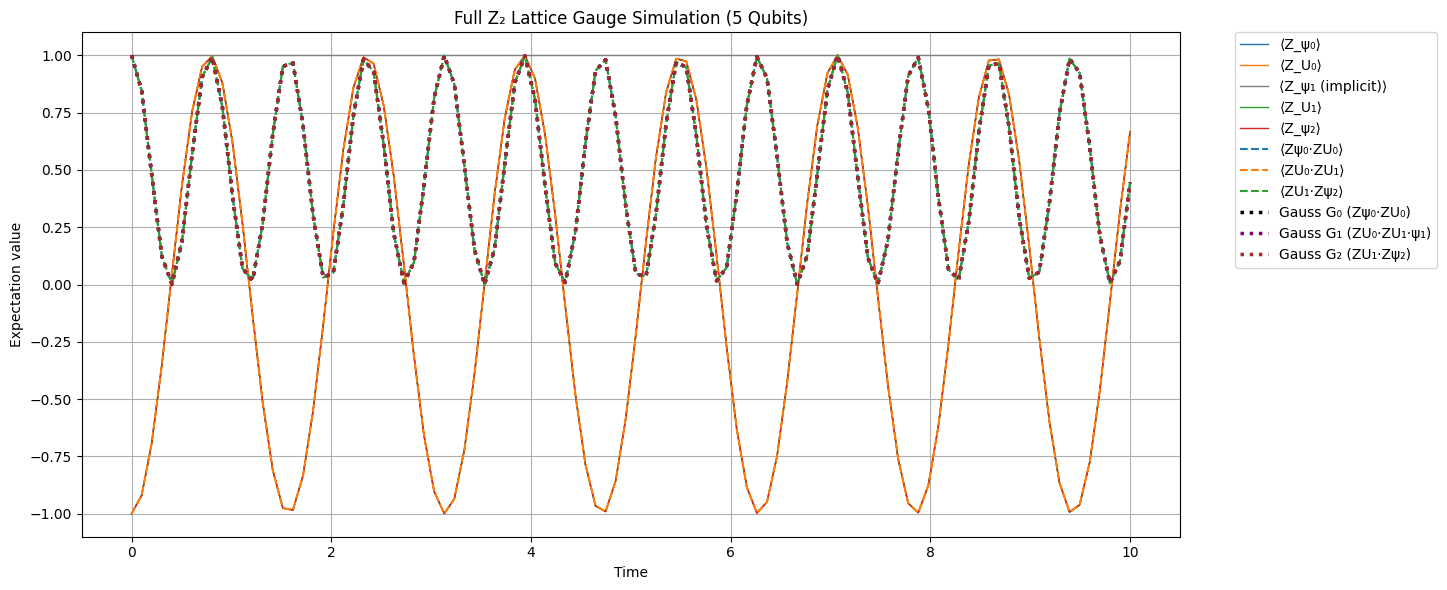

In [9]:
plt.figure(figsize=(12, 6))

# Plot Z expectations
labels = ['ψ₀', 'U₀', 'ψ₁ (implicit)', 'U₁', 'ψ₂']
colors = ['tab:blue', 'tab:orange', 'gray', 'tab:green', 'tab:red']
for i in range(5):
    plt.plot(times, z_expect[i], label=f"⟨Z_{labels[i]}⟩", color=colors[i], linestyle='-', linewidth=1)

# Plot ZZ interactions
plt.plot(times, zz_01, label="⟨Zψ₀·ZU₀⟩", linestyle='--', color='tab:blue')
plt.plot(times, zz_13, label="⟨ZU₀·ZU₁⟩", linestyle='--', color='tab:orange')
plt.plot(times, zz_34, label="⟨ZU₁·Zψ₂⟩", linestyle='--', color='tab:green')

# Plot Gauss laws
plt.plot(times, g0_expect, label="Gauss G₀ (Zψ₀·ZU₀)", linestyle=':', linewidth=2.5, color='black')
plt.plot(times, g1_expect, label="Gauss G₁ (ZU₀·ZU₁·ψ₁)", linestyle=':', linewidth=2.5, color='purple')
plt.plot(times, g2_expect, label="Gauss G₂ (ZU₁·Zψ₂)", linestyle=':', linewidth=2.5, color='brown')

# Plot decorations
plt.xlabel("Time")
plt.ylabel("Expectation value")
plt.title("Full Z₂ Lattice Gauge Simulation (5 Qubits)")
plt.grid(True)
plt.tight_layout()

# Place legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
